# Обработка GPX-треков и анализ местности

### Что такое GPX и как его парсить

GPX (GPS Exchange Format) — открытый XML-формат для хранения GPS-данных.  
Используется в спортивных приложениях (Strava, Garmin Connect, Komoot), навигаторах и трекерах.

Основные элементы:
- **track** → маршрут
  - **segment** → непрерывный кусок маршрута
    - **point** → отдельная GPS-точка с координатами, высотой, временем

Мы будем извлекать только координаты и высоту — этого достаточно для большинства задач анализа.

In [22]:
import glob
import gpxpy
import pandas as pd

# Находим все .gpx файлы в текущей директории
gpx_files = glob.glob("data//gpx//*.gpx")

if not gpx_files:
    print("Внимание: GPX-файлы не найдены. Поместите их в ту же папку, что и ноутбук.")
else:
    print(f"Найдено {len(gpx_files)} GPX-файлов")

# Список для хранения данных
records = []

for file_idx, filename in enumerate(gpx_files):
    with open(filename, 'r', encoding='utf-8') as f:
        gpx = gpxpy.parse(f)
        print(gpx)
    
    for track_idx, track in enumerate(gpx.tracks):
        for segment in track.segments:
            for point in segment.points:
                records.append({
                    'file_id': file_idx,                  # идентификатор исходного файла
                    'filename': filename,
                    'track_id': f"{file_idx}_{track_idx}", # уникальный id трека
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                    'elevation': point.elevation,
                    'time': point.time
                })

# # Основной DataFrame с точками
df_points = pd.DataFrame(records)
print(f"Всего точек: {len(df_points)}")
df_points.head()

Найдено 1 GPX-файлов
GPX(tracks=[GPXTrack(segments=[GPXTrackSegment(points=[...])])])
Всего точек: 1702


,file_id,filename,track_id,latitude,longitude,elevation,time
0,0,data//gpx\851S46XD.gpx,0_0,44.385216,39.190845,224.6,2025-08-18 12:47:24+00:00
1,0,data//gpx\851S46XD.gpx,0_0,44.384964,39.190851,235.4,2025-08-18 12:48:42+00:00
2,0,data//gpx\851S46XD.gpx,0_0,44.384895,39.190798,224.6,2025-08-18 12:49:00+00:00
3,0,data//gpx\851S46XD.gpx,0_0,44.384965,39.189912,194.9,2025-08-18 12:52:06+00:00
4,0,data//gpx\851S46XD.gpx,0_0,44.384987,39.189847,193.4,2025-08-18 12:52:12+00:00


### Преобразование в геометрию (GeoPandas + LineString)

Одиночные точки неудобны для геоанализа и визуализации.  
Мы объединяем все точки одного трека в объект **LineString** — это позволяет:
- корректно работать с проекциями
- накладывать трек на карту
- считать длину, буферы, пересечения и т.д.

GeoPandas — расширение Pandas для пространственных данных.


In [29]:
import geopandas as gpd
from shapely.geometry import LineString

# Группируем точки по трекам и создаём LineString
tracks_gdf = (
    df_points
    .groupby('track_id')
    .apply(lambda g: LineString(zip(g.longitude, g.latitude)))
    .reset_index(name='geometry')
)

# Создаём GeoDataFrame с правильной системой координат
gdf_tracks = gpd.GeoDataFrame(tracks_gdf, geometry='geometry', crs="EPSG:4326")

print(f"Количество уникальных треков: {len(gdf_tracks)}")
gdf_tracks.head()


Количество уникальных треков: 1


C:\Users\Руслан\AppData\Local\Temp\ipykernel_17040\1516698395.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: LineString(zip(g.longitude, g.latitude)))


,track_id,geometry
0,0_0,"LINESTRING (39.19085 44.38522, 39.19085 44.384..."


### Перепроецирование в Web Mercator (EPSG:3857)

GPS-координаты приходят в **EPSG:4326** (градусы).  
Онлайн-карты (OpenStreetMap, Google, Yandex) используют **EPSG:3857** (Web Mercator) — координаты в метрах.  
Без перепроецирования трек будет визуально искажён при наложении на карту.

In [30]:
gdf_tracks_web = gdf_tracks.to_crs(epsg=3857)
gdf_tracks_web.head()

,track_id,geometry
0,0_0,"LINESTRING (4362704.931 5525250.079, 4362705.5..."


## Визуализация треков на реальной карте

Простое наложение статичного изображения карты не работает — нет геопривязки.  
Библиотека **contextily** автоматически подгружает тайлы OpenStreetMap и правильно их позиционирует под наши данные в EPSG:3857.


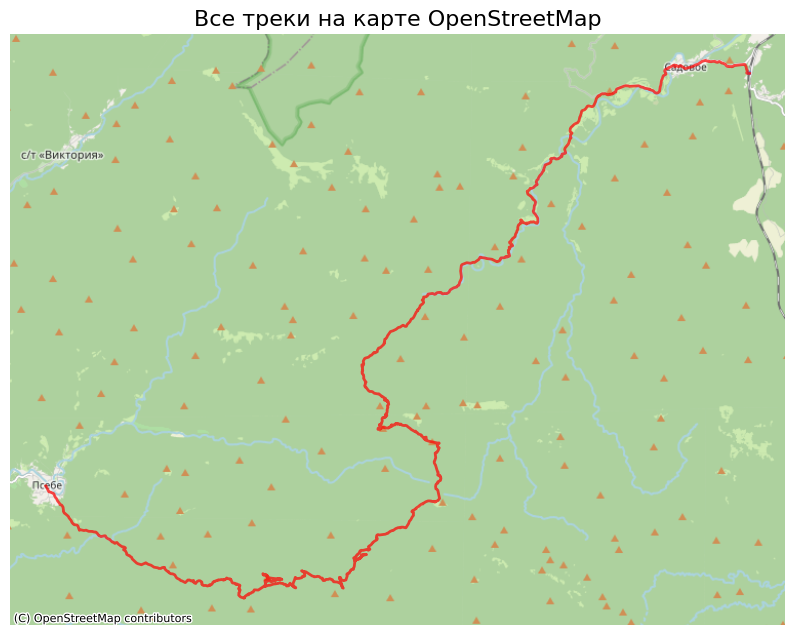

In [33]:
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(10, 10))

gdf_tracks_web.plot(ax=ax, linewidth=2, color='red', alpha=0.7)

# Добавляем подложку OSM
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.title("Все треки на карте OpenStreetMap", fontsize=16)
plt.show()


### Сохранение изображений треков для ML (компьютерное зрение)

Для задач CV (классификация маршрута, оценка риска по картинке) нужны изображения треков.  
Генерируем отдельное изображение для каждого трека с фиксированным зумом.


In [ ]:
import os
from PIL import Image

os.makedirs("images", exist_ok=True)
os.makedirs("images_resized", exist_ok=True)

for idx, row in gdf_tracks_web.iterrows():
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_axis_off()
    # Рисуем только текущий трек
    gpd.GeoSeries([row.geometry]).plot(ax=ax, linewidth=3, color='red')
    
    # Подложка карты
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=14)
    # Сохраняем
    filepath = f"images/track_{idx}.png"
    fig.savefig(filepath, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    # Ресайз до 512x512 (подходит для большинства моделей)
    img = Image.open(filepath)
    img_resized = img.resize((512, 512), Image.LANCZOS)
    img_resized.save(f"images_resized/track_{idx}.png")

print(f"Сохранено {len(gdf_tracks_web)} изображений (оригиналы и ресайз 512x512)")

1
2
3
Сохранено 1 изображений (оригиналы и ресайз 512x512)


### Якорные координаты трека (центроид)

Для запросов к геосервисам нужен один представительский пункт на трек.  
Самый простой и надёжный — среднее арифметическое координат (центроид точек).


In [36]:
track_centers = (
    df_points
    .groupby('track_id')[['latitude', 'longitude']]
    .mean()
    .reset_index()
)

# Добавляем соответствие с индексом в gdf_tracks_web
track_centers['row_idx'] = track_centers.index
track_centers.head()

,track_id,latitude,longitude,row_idx
0,0_0,44.305821,39.069898,0


### Получение данных о местности вокруг трека (OSMnx — рекомендуемый способ)

**Overpass API** даёт сырые данные OSM, но писать запросы вручную сложно.  
**OSMnx** — высокоуровневая библиотека, которая:

- автоматически формирует правильные Overpass-запросы
- возвращает готовый GeoDataFrame
- удобна в production и для ML

Мы извлекаем все объекты в радиусе 500 м от центра трека по ключевым тегам.


In [43]:
import osmnx as ox

# Настраиваем OSMnx (один раз)
ox.settings.overpass_settings = '[out:json][timeout:90]'

features_list = []

for _, row in track_centers.iterrows():
    try:
        gdf_features = ox.features_from_point(
            center_point=(row.latitude, row.longitude),
            tags={
                'highway': True,
                'building': True,
                'amenity': True,
                'leisure': True,
                'natural': True,
                'landuse': True,
                'shop': True
            },
            dist=500
        )
        
        # Собираем уникальные значения важных тегов
        amenities = gdf_features['amenity'].dropna().unique().tolist() if 'amenity' in gdf_features else []
        highways = gdf_features['highway'].dropna().unique().tolist() if 'highway' in gdf_features else []
        natural = gdf_features['natural'].dropna().unique().tolist() if 'natural' in gdf_features else []
        
        features_list.append({
            'amenities': amenities,
            'highways': highways,
            'natural': natural,
            'total_objects': len(gdf_features)
        })
    except Exception as e:
        print(f"Ошибка для трека {row.track_id}: {e}")
        features_list.append({'amenities': [], 'highways': [], 'natural': [], 'total_objects': 0})

# Добавляем в таблицу
track_centers['amenities'] = [f['amenities'] for f in features_list]
track_centers['highways'] = [f['highways'] for f in features_list]
track_centers['natural'] = [f['natural'] for f in features_list]
track_centers['total_objects_osm'] = [f['total_objects'] for f in features_list]

track_centers.head()


,track_id,latitude,longitude,row_idx,amenities,highways,natural,total_objects_osm
0,0_0,44.305821,39.069898,0,[],[path],"[peak, cave_entrance, wood, grassland]",9


### Итоговый мультимодальный датасет


In [45]:
# Объединяем всё в одну таблицу
final_dataset = track_centers.copy()
final_dataset['image_path'] = [f"images_resized/track_{i}.png" for i in final_dataset['row_idx']]
final_dataset['track_length_m'] = gdf_tracks_web.length  # длина в метрах (EPSG:3857)

final_dataset.head()


,track_id,latitude,longitude,row_idx,amenities,highways,natural,total_objects_osm,image_path,track_length_m
0,0_0,44.305821,39.069898,0,[],[path],"[peak, cave_entrance, wood, grassland]",9,images_resized/track_0.png,60849.602983


**Что мы получили:**

- `track_id` — уникальный идентификатор
- `latitude`, `longitude` — центр трека
- `image_path` — путь к изображению 512×512
- `amenities`, `highways`, `natural` — списки объектов инфраструктуры
- `total_objects_osm` — плотность объектов
- `track_length_m` — длина маршрута

Этот датасет идеально подходит для:

- мультимодальных моделей (изображение + табличные/текстовые признаки)
- задач оценки риска/проходимости
- кластеризации маршрутов по типу местности